In [111]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse.linalg
import time
from scipy.sparse.linalg import eigs

In [92]:
#create triangle of a given side length that is positioned upright
def create_triangle(min_len,max_len):
    side_length = np.random.random() * (max_len - min_len) + min_len
    base_coor = (0, 0)
    c = np.tan(np.pi / 6) * (side_length / 2)
    A = (base_coor[0], base_coor[1] + np.sqrt(3) / 2 * side_length - c)
    B = (base_coor[0] -side_length / 2, base_coor[1]  -c)
    C = (base_coor[0] + side_length / 2, base_coor[1]  -c)
    return np.array([A, B, C])

In [93]:
# Help determine if the vertex of the new triangle already exists in the graph,
# if exists, return the position symmetric in respect to the line connected by
# node1 and node2
def triangle_helper(node1,node2,vert_locs):
    node1 = np.array(node1)
    node2 = np.array(node2)

    #Find the center of the edge
    center = np.array([(node1[0] + node2[0]) / 2, (node1[1] + node2[1])/2])

    #find the direction of the new node
    vec = node1 - node2
    len_vec = (vec[0]**2 + vec[1]**2)**(0.5)
    dir = np.dot(np.array([[0,-1],[1,0]]), (vec / len_vec))

    #Find the two candidate points
    pt1 = center + dir * np.sqrt(3) / 2 * len_vec
    pt2 = center + dir * np.sqrt(3) / 2 * len_vec * (-1)

    min_dis_1 = 10000
    closest_neighbor_1 = None
    min_dis_2 = 10000
    closest_neighbor_2 = None

    #check if pt1 is already in vert_locs
    for i in range(len(vert_locs)):
        vert = vert_locs[i]
        dis = np.sqrt((vert[0] - pt1[0])**2 + (vert[1] - pt1[1])**2)
        if (dis < min_dis_1):
            min_dis_1 = dis
            closest_neighbor_1 = i

    for i in range(len(vert_locs)):
        vert = vert_locs[i]
        dis = np.sqrt((vert[0] - pt2[0])**2 + (vert[1] - pt2[1])**2)
        if (dis < min_dis_2):
            min_dis_2 = dis
            closest_neighbor_2 = i

    #closure
    if (min_dis_1 < len_vec / 100 and min_dis_2 < len_vec/100):
        return True, [pt1,pt2,closest_neighbor_1,closest_neighbor_2]

    else:
        if (min_dis_1 <= len_vec / 100):
            return False, [pt2]
        else:
            return False, [pt1]

# Take in two nodes, return the center of the line that connects these two nodes
def edge_sampler(node1,node2):
    node1 = np.array(node1)
    node2 = np.array(node2)
    center = np.array([(node1[0] + node2[0]) / 2, (node1[1] + node2[1])/2])
    return int(center[0]),int(center[1])

In [94]:
# This function takes in all the information of a triangular mesh, then randomly adds only one more triangle to the existing mesh
def create_multi_triangle_rec(vertice_locations, edges, outer_edges, triangles):
    #Pick a random edge, and assign the original vertices.
    rand_idx = np.random.randint(0,len(outer_edges))
    orig_ver1 = list(outer_edges[rand_idx])[0]
    orig_ver2 = list(outer_edges[rand_idx])[1]
    closure, new_vertexs = triangle_helper(vertice_locations[orig_ver1],vertice_locations[orig_ver2], vertice_locations)

    #Tell the user which operation is performed (0/1/2/3)
    operation = 0
    if closure == False:
        #operation 0, add one node, two edges and remove two outer edges.
        new_vertex = new_vertexs[0]

        #Create new vertex and edges
        vertice_locations.append((new_vertex[0],new_vertex[1]))
        new_edge1 = set([orig_ver1,len(vertice_locations)-1])
        new_edge2 = set([orig_ver2,len(vertice_locations)-1])

        #Add new edges to existing list
        edges.append(new_edge1)
        edges.append(new_edge2)

        triangles.append(set([orig_ver1, orig_ver2, len(vertice_locations)-1]))

        #Remove old outer edges and add new ones
        outer_edges.remove(set([orig_ver1,orig_ver2]))
        outer_edges.append(new_edge1)
        outer_edges.append(new_edge2)


    else:
        clo_nei1 = new_vertexs[2]
        clo_nei2 = new_vertexs[3]

        #Logic Processing to determine which operation to perform
        c1o1 = set([clo_nei1, orig_ver1]) not in edges
        c1o2 = set([clo_nei1, orig_ver2]) not in edges
        c2o1 = set([clo_nei2, orig_ver1]) not in edges
        c2o2 = set([clo_nei2, orig_ver2]) not in edges


        #operation 1, add no edge or node and remove three edges from outer edge
        if ((not c1o1) and (not c1o2) ) and ((not c2o1) and (not c2o2)):
            if set([orig_ver1,orig_ver2,clo_nei1]) in triangles:
                triangles.append(set([clo_nei2,orig_ver1,orig_ver2]))

                #Remove the three outer edges that form this triangle
                outer_edges.remove(set([orig_ver1,orig_ver2]))
                outer_edges.remove(set([clo_nei2,orig_ver1]))
                outer_edges.remove(set([clo_nei2,orig_ver2]))


            else:
                triangles.append(set([clo_nei1,orig_ver1,orig_ver2]))

                #Remove the three outer edges that form this triangle
                outer_edges.remove(set([orig_ver1,orig_ver2]))
                outer_edges.remove(set([clo_nei1,orig_ver1]))
                outer_edges.remove(set([clo_nei1,orig_ver2]))

            operation = 1
        #operation 2, add two edges and remove one edge from outer edces.
        elif (c1o1 and c1o2) or (c2o1 and c2o2):
            #the following if statement decides which side to add
            if (c1o1 and c1o2):
                #Create new edge
                new_edge1 = set([clo_nei1,orig_ver1])
                new_edge2 = set([clo_nei1,orig_ver2])

                #Add to existing list of edges
                edges.append(new_edge1)
                edges.append(new_edge2)

                triangles.append(set([clo_nei1,orig_ver1,orig_ver2]))

                outer_edges.remove(outer_edges[rand_idx])

                outer_edges.append(new_edge1)
                outer_edges.append(new_edge2)

            else:
                #Create new edge
                new_edge1 = set([clo_nei2,orig_ver1])
                new_edge2 = set([clo_nei2,orig_ver2])

                #Add to existing list of edges
                edges.append(new_edge1)
                edges.append(new_edge2)

                triangles.append(set([clo_nei2,orig_ver1,orig_ver2]))

                #Remove old and add new outer edges
                outer_edges.remove(outer_edges[rand_idx])
                outer_edges.append(new_edge1)
                outer_edges.append(new_edge2)

            operation = 2

        #operation 3, add one edge and remove two edges from outer edges.
        else:
            #The following if statements determine which side to add the edge to, there are a total of four scenarios.
            #subcase 0
            if set([orig_ver1,clo_nei1]) not in edges:
                #Create new edge
                new_edge = set([orig_ver1,clo_nei1])

                #Add to existing list of edges
                edges.append(new_edge)

                triangles.append(set([orig_ver1,orig_ver2,clo_nei1]))


                #Remove old and add new outer edges
                outer_edges.remove(outer_edges[rand_idx])
                outer_edges.remove(set([clo_nei1,orig_ver2]))
                outer_edges.append(new_edge)

            #subcase 1
            elif set([orig_ver1,clo_nei2]) not in edges:
                #Create new edge
                new_edge = set([orig_ver1,clo_nei2])

                #Add to existing list of edges
                edges.append(new_edge)

                triangles.append(set([orig_ver1,orig_ver2,clo_nei2]))

                #Remove old and add new outer edges
                outer_edges.remove(outer_edges[rand_idx])
                outer_edges.remove(set([clo_nei2,orig_ver2]))
                outer_edges.append(new_edge)

            #subcase 2
            elif set([orig_ver2,clo_nei1]) not in edges:
                #Create new edge
                new_edge = set([orig_ver2,clo_nei1])

                #Add to existing list of edges
                edges.append(new_edge)

                triangles.append(set([orig_ver1,orig_ver2,clo_nei1]))

                #Remove old and add new outer edges
                outer_edges.remove(outer_edges[rand_idx])
                outer_edges.remove(set([clo_nei1,orig_ver1]))
                outer_edges.append(new_edge)

            #subcase 3
            else:
                #Create new edge
                new_edge = set([orig_ver2,clo_nei2])

                #Add to existing list of edges
                edges.append(new_edge)
                triangles.append(set([orig_ver1,orig_ver2,clo_nei2]))

                #Remove old and add new outer edges
                outer_edges.remove(outer_edges[rand_idx])
                outer_edges.remove(set([clo_nei2,orig_ver1]))
                outer_edges.append(new_edge)

            operation = 3

    return vertice_locations, edges, outer_edges, triangles, operation

In [201]:
# Given a list of edges, this function initializes a Networkx graph then adds edges to the graph
def mesh_to_graph(edges):
    G = nx.Graph()
    for edge in edges:
        e = list(edge)
        G.add_edge(e[0],e[1])

    lap_mat = nx.laplacian_matrix(G).toarray()

    evals, U = np.linalg.eigh(lap_mat)
    return evals, U

def mesh_to_lap(edges):
    G = nx.Graph()
    for edge in edges:
        e = list(edge)
        G.add_edge(e[0],e[1])

    lap_mat = nx.laplacian_matrix(G)

    return lap_mat

def mesh_to_sparse(edges):
    t = time.time()

    row = []
    col = []
    num_edges = len(edges)
    degrees = []

    for edge in edges:
        e = list(edge)
        row.append(e[0])
        col.append(e[1])

    roww = row + col
    coll = col + row

    num_nodes = max(roww) + 1

    diag_indices = []
    diag_data = []

    for i in range(num_nodes):
        count_occurence = roww.count(i)
        diag_indices.append(i)
        diag_data.append(count_occurence)

    data = [-1 for i in range(num_edges * 2)]
    roww += diag_indices
    coll += diag_indices
    data += diag_data

    print(time.time() - t)

    return scipy.sparse.csr_array((data,(roww,coll))).asfptype()


def sparse_to_hks(spar,ts):
    print(spar.toarray().shape)
    w,v = eigs(spar)

    print(w.shape)

    w = np.real(w)
    v = np.real(v)

    e_lambdas = np.exp(w)

    e_lambdas_t = []

    for t in ts:
        e_lambdas_t.append(e_lambdas ** t)

    print(e_lambdas_t)


    return w,v


# Given a list of triangles, this function converts all the triangles to nodes instead of triangle vertices to nodes.
def mesh_to_graph2(triangles):
    G = nx.Graph()

    #Go through all triangles
    for i in range(len(triangles)):
        curr_triangle = triangles[i]
        num_nei = 0
        for j in range(len(triangles)):
            #A node can have at most 6 edges
            if (i == j or num_nei == 6):
                pass
            else:
                neighbor_triangle = triangles[j]
                union = curr_triangle.union(neighbor_triangle)
                #If they are connected by an edge
                if (len(union) == 4):
                    if (not G.has_edge(i,j)) and (not G.has_edge(j,i)):
                        G.add_edge(i,j, weight=1)
                    num_nei += 1
                #If they are connected by a node
                elif len(union) == 5:
                    if (not G.has_edge(i,j)) and (not G.has_edge(j,i)):
                        G.add_edge(i,j, weight=0.1)
                    num_nei += 1


    #lap_mat = nx.laplacian_matrix(G).toarray()
    #evals, U = np.linalg.eigh(lap_mat)
    return evals,U, G
    #return G


In [202]:
# source is the first triangle in the triangular mesh
source = create_triangle(5,5)
# records the locations of the first triangle's vertices.
vertice_locations = [(source[0,0],source[0,1]),(source[1,0],source[1,1]),(source[2,0],source[2,1])]
# records the edges of the first triangle's vertices
edges = [{0, 1}, {0, 2}, {1, 2}]
# the first triangle has all three of its edges as outer edges
outer_edges = edges.copy()
# add the first triangle into triangles list which keeps track of all the triangles.
triangles = [{0, 1, 2}]

In [215]:
# Heat kernel signature at t
def hkt(t,evals,U):
    exp = np.exp(t*evals)
    lamb = np.diag(exp)
    #print(U.dot(lamb).dot(U.T))
    return U.dot(lamb).dot(U.T)

# Calculate a bunch of heat kernel signatures given ts
def hks(ts,evals,U):
    toret = np.empty([ts.shape[0]])
    for i in range(ts.shape[0]):
        t = ts[i]
        kernel = hkt(t,evals,U)
        diagonal = np.diag(kernel)
        toret[i] = np.mean(diagonal)

    return toret

In [ ]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [216]:
# source is the first triangle in the triangular mesh
source = create_triangle(5,5)
# records the locations of the first triangle's vertices.
vertice_locations = [(source[0,0],source[0,1]),(source[1,0],source[1,1]),(source[2,0],source[2,1])]
# records the edges of the first triangle's vertices
edges = [{0, 1}, {0, 2}, {1, 2}]
# the first triangle has all three of its edges as outer edges
outer_edges = edges.copy()
# add the first triangle into triangles list which keeps track of all the triangles.
triangles = [{0, 1, 2}]

ts = np.random.random([10])

operations = []
signatures = []
dists = []
dists_euc = []


# The following for-loop generates a random triangular mesh graph by randomly adding one triangle each time
# Every time a new triangle is added, the new heat kernel signature will be added into signatures. Corresponding operations/cases will be added
# into operations list, and euclidean distance differences of heat kernel signature between each triangle addition will be calculated and added to dists.
for n in range(501):
    vertice_locations, edges, outer_edges, triangles, operation = create_multi_triangle_rec(vertice_locations, edges, outer_edges, triangles)
    if len(signatures) == 0:
        #evals, U = mesh_to_graph2(triangles)
        evals, U = mesh_to_graph(edges)
        signature = hks(ts,evals,U)
        signatures.append(signature)


    else:
        #evals, U = mesh_to_graph2(triangles)
        evals, U = mesh_to_graph(edges)
        signature = hks(ts,evals,U)
        signatures.append(signature)
        diff = signatures[len(signatures)-1] - signatures[len(signatures)-2]
        dists_euc.append(np.sqrt(diff.dot(diff)))
        dists.append(np.mean(diff))
        operations.append(operation)


In [195]:
# source is the first triangle in the triangular mesh
source = create_triangle(5,5)
# records the locations of the first triangle's vertices.
vertice_locations = [(source[0,0],source[0,1]),(source[1,0],source[1,1]),(source[2,0],source[2,1])]
# records the edges of the first triangle's vertices
edges = [{0, 1}, {0, 2}, {1, 2}]
# the first triangle has all three of its edges as outer edges
outer_edges = edges.copy()
# add the first triangle into triangles list which keeps track of all the triangles.
triangles = [{0, 1, 2}]

ts = np.random.random([10])

operations = []
signatures = []
dists = []
dists_euc = []

# The following for-loop generates a random triangular mesh graph by randomly adding one triangle each time
# Every time a new triangle is added, the new heat kernel signature will be added into signatures. Corresponding operations/cases will be added
# into operations list, and euclidean distance differences of heat kernel signature between each triangle addition will be calculated and added to dists.
for n in range(501):
    vertice_locations, edges, outer_edges, triangles, operation = create_multi_triangle_rec(vertice_locations, edges, outer_edges, triangles)
    if len(signatures) == 0:
        #evals, U = mesh_to_graph2(triangles)
        evals, U = mesh_to_graph(edges)
        signature = hks(ts,evals,U)
        signatures.append(signature)


    else:
        #evals, U = mesh_to_graph2(triangles)
        evals, U = mesh_to_graph(edges)
        signature = hks(ts,evals,U)
        signatures.append(signature)
        diff = signatures[len(signatures)-1] - signatures[len(signatures)-2]
        dists_euc.append(np.sqrt(diff.dot(diff)))
        dists.append(np.mean(diff))
        operations.append(operation)


[1.         1.33396944 1.77947447 1.77947447]
[ 1.          5.72258516 32.74798089 32.74798089]
[ 1.          3.38695631 11.47147303 11.47147303]
[1.         1.67256734 2.79748151 2.79748151]
[1.         1.07492521 1.1554642  1.1554642 ]
[ 1.          4.81604561 23.19429535 23.19429535]
[1.         2.08305401 4.33911401 4.33911401]
[1.         1.57346774 2.47580073 2.47580073]
[ 1.          3.48491105 12.14460502 12.14460502]
[1.         1.21579823 1.47816533 1.47816533]
[1.         1.25668757 1.54070262 1.8889059  2.05525022]
[ 1.          3.98739967 13.68952554 46.99882751 78.33947566]
[ 1.          2.6307673   6.23324779 14.76883873 21.11173791]
[1.         1.50355511 2.16309413 3.11194193 3.61792059]
[1.         1.05896011 1.1144674  1.17288422 1.1979691 ]
[ 1.          3.47776907 10.56904842 32.119667   50.90101926]
[1.         1.78935079 3.00642792 5.05133419 6.26255173]
[1.         1.43247565 1.97372556 2.71948258 3.10559349]
[ 1.          2.69091587  6.50560283 15.72805329 22.6

KeyboardInterrupt: 

In [467]:
d = [[],[],[],[]]
d_euc = [[],[],[],[]]
print(len(operations),len(dists))

# The following loop adds euclidean distance and average of change in each dimension to the corresponding lists
for i in range(len(operations)):
    d[operations[i]].append(dists[i])
    d_euc[operations[i]].append(dists_euc[i])




500 500


In [477]:
d[2]

[3.019665270340321,
 1.6307743196318498,
 1.7970825384883569,
 2.6200289857091072,
 1.3952646302708953,
 2.6003115871893243,
 1.4331584837598728,
 1.1955626827118189,
 1.1085918838086075,
 0.6296109582879643,
 0.7226161882654049,
 1.144548103698448,
 1.0754529845514564,
 0.5415006320910691,
 0.9098316482485641,
 0.2015040432829191,
 0.5101508750136892,
 0.5647490191586849,
 0.43921196115944944,
 0.8571326189841676,
 0.926643123750867,
 0.4604547293988929,
 0.5561643632598845,
 1.5830978835432978,
 0.4046067984280568,
 0.44067403025648105,
 0.3109896108795165,
 0.2137244332178135,
 0.21090483843512878,
 0.34188240961303995,
 0.3835122154735144,
 0.1791767674979185,
 0.2683590941832793,
 0.1706614392159747,
 0.16941704042019384,
 0.20967826705677353,
 0.11625085012982536,
 0.28904996449175124,
 0.12110210854374652,
 0.11637918230323038,
 0.11398511466063055,
 0.15982437512857336,
 0.10420707056919801,
 0.1726940610062779,
 0.14515415897838618,
 0.07229306338379829,
 4.518041853606997,
 1

8104 592 660 4144
0.04892976561939031
0.0
1.6211139720876944
0.6004620100227495


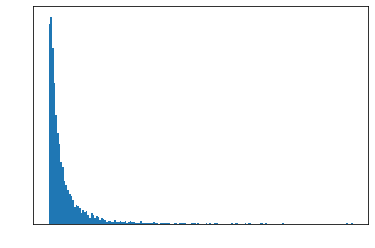

In [478]:


print(len(d[0]),len(d[1]),len(d[2]),len(d[3]))



print(np.mean(d[0]))
print(np.mean(d[1]))
print(np.mean(d[2]))
print(np.mean(d[3]))

import matplotlib as mpl
mpl.rcParams['text.color'] = 'w'
mpl.rcParams['xtick.color'] = 'w'
mpl.rcParams['ytick.color'] = 'w'
mpl.rcParams['axes.labelcolor'] = 'w'

plt.hist(d[3],bins = 180)
plt.savefig('output.png')

In [474]:
np.std(d[3])

0.8841793111748917